Постановка. Дана некоторая матрица $Y$ размера $n\times n$ (изображение), у которой известно только некоторое количество элементов $Y_{ij}: (i,j) \notin E$. Нужно как-то восстановить неизвестные элементы (пиксели). Возьмём популярную постановку приближения $Y$ матрицей малого ранга, т.е. будем решать задачу
$$ \min\limits_{\substack{X: \\ X_{ij} = Y_{ij} \\ (i, j) \in E}} rank(X)$$  
К сожалению, функция $rank(X)$ не является выпуклой, поэтому для такой задачи неизвестны эффективные методы. Поэтому возьмём выпуклую аппроксимацию функции $rank(X)$ выпуклой функцией $\|X\|_{*} = \sum_{i=1}^n \sigma_i(X)$, где $\sigma_i(X)$ - $i$-ое сингулярное значение матрицы X.  
Почему задача
$$ \min\limits_{\substack{X: \\ X_{ij} = Y_{ij} \\ (i, j) \in E}} \|X\|_{*}$$
хорошая приближает исходную задачу? Ядерная норма - это $l_1$ норма вектора из сингулярных значений матрицы X, а $l_1$-регуляризация чаще всего приводит к локальному оптимуму, достигающихся на разряженных векторах, а $rank(X) =$ число ненулевых сингулярных значений матрицы X.
Для решения нашей задачи $$ \min\limits_{\substack{X: \\ X_{ij} = Y_{ij} \\ (i, j) \in E}} \|X\|_{*}$$ реализуем несколько методов.

Proximal Gradient Descent и Proximal Subgradient Descent

Есть две поставновки задачи, пригодных для решения PGD.  
$\textbf{Первая постановка.}$    
Пусть $Y = \{X | X_{i, j} = Y_{i, j}, (i, j) \in E\}$. 
$\min [\|X\|_* + I_Y(X)]$, где $I_Y(X)$ - индикатор того, что матрица X лежит в множестве Y. В этой постановке $f(X) = g(X)+h(X)$, где $g(X) =  \|X\|_*$ - "дифференцируемая" (и выпуклая) функция из PGD, по градиенту (субградиенту) которой идём, а $h(x) = I_Y(X)$ просто выпуклая функция, по которой строится проксимальное отображения.  
Тогда $prox_{h, t}(X) = argmin_Z[\frac{1}{2t}\|Z-X\|_2^2 + h(Z)] = argmin_Z[\frac{1}{2t}\|Z-X\|_2^2 + I_Y(Z)] = P_Y(X)$, где $P_Y(Z)$ - проекция матрицы X на $Y$.
Осталось найти $\partial \|X\|_*$.  
$\|\cdot\|_*$ - ортогональный инвариант: $F = \|\cdot\|_* = f \circ \sigma$, где $f$ - сумма модулей (для абсолютной симметричности) компонент вектора, $\sigma(X)$ - вектор сингулярных значений матрицы.  
Известно, что субдифференциал ортогонального инварианта есть $\partial F(X) = \{ U \mathrm{diag}(\mu) V^T \mid \mu \in \partial f(\sigma(X)) \}$, где $X = Udiag(\sigma(X))V^T$ - SVD-разложение X.  
У нас $\mu \in \partial \|\sigma(X)\|_1$, т.е. $\mu_k = 1$, если $\sigma_k(X) > 0$, и $\mu_k \in [-1, 1]$, если $\sigma_k(X) = 0$. Сразу можно заметить, что $UV^T$ всегда лежит в субдифференциале ядерной нормы. Именно матрицу $UV^T$ я и буду использовать в качестве "градиента" в этой реализации PGD. Но так как $\|X\|_*$ не везде дифференцируема, то на самом деле мы получаем Proximal Subgradient Descenе.  
$X_{k+1} = prox_{h, t_k}(X_k - t_k\partial \|X_k\|_*) = P_Y(X_k - t_kU_kV_k^T)$, где $X_k = U_k\Sigma_k V_k^T$ - SVD.  
Итого: начинаю с $X_0$, раскладываю $X_k = U_k\Sigma_k V_k^T$, $X_{k+1} = P_Y(X_k - t_kU_kV_K^T)$.  
Это реализовано в функциях prox_alg_const (с постоянным шагом и шагом 1/k) и prox_alg_armijo (с выбором $t_k$ из условия достаточного убывания).  
Если присмотреться к алгоритму, то он делает следующее: сначала из всех сингулярных значений вычитает $t_k$, из-за чего в $\Sigma$ могут даже возникнуть отрицательные значения на диагонали и у SVD могут измениться U и $V^T$, а ядерная норма может по итогу даже увеличиться (вот он субградиентный спуск!). Затем берём проекцию полученной матрицы на Y, чтобы вернуться в нужное множество и т.д.  
Так как для $X=0$ $UV^T = I$, возникают проблемы со сходимостью к матрицам очень маленького ранга (например, к 0, если в задаче все $Y_{i,j} =0$ или в случае только нескольких ненулевых сингулярных значений у решения задачи). В этом плане вторая постановка даёт более хороший алгоритм.  

$\textbf{Вторая постановка.}$  
Пусть матрица B: $$B_{i,j} = \begin{cases} Y_{i, j}, (i, j) \in E \\ 0, \text{иначе}\end{cases} $$
$\min[ \lambda\|X\|_* + \frac{1}{2} \|(X-B)*I(E)\|_2^2]$, где $*I(E)$  - это покомпонентное умножение на матрицу из 0 (если $(i, j) \notin E$) и 1 (если $(i, j) \in E$). Понятно, что решение этой задачи может даже не лежать  в Y, т.е. это только некоторое приближение к исходной задаче (с управляемым коэффициентом-штрафом $\lambda >0$), но за счёт нескольких трюков в процессе вывода аналитической записи шагов, получим, что каждый $X_k \in Y$, и на практических экспериментах этот метод очень не плох.  
Здесь $g(X) = \frac{1}{2} \|(X-Y)*I(E)\|_2^2$ - выпуклая и всюду дифференцируемая функция, $h(X) = \lambda\|X\|_*$ - просто выпуклая функция, по которой строится проксимальное отображение. 
$prox_{h, t}(X) = argmin_Z [\frac{1}{2t} \|Z-X\|_2^2 + \lambda\|Z\|_*]$. Ищу минимум.  
$0 \in \partial [\frac{1}{2t} \|Z-X\|_2^2 + \lambda\|Z\|_*]$. Пусть $X = U\Sigma V^T$. Буду искать точку Z в виде $U\Sigma_z V^T$, тогда надо $\sigma(\Sigma) - \sigma(\Sigma_z) \in \lambda t \{\mu\}$ (это вектора, все обозначения из вывода субдифференциала выше). Тогда нам подходит $\Sigma_z = max((\Sigma - \lambda t I), 0)$: если $\Sigma_{ii} > \lambda t$, то есть только $\mu_i = 1$ и тогда получаем $\Sigma_{ii} - (\Sigma_{ii} - \lambda t) \in \lambda t \{1\}$. Если $\Sigma_{ii} <= \lambda t$, то i-ое сингулярное значение матрицы Z равно 0 и в множестве {$\mu$} в i-ой компоненте находится целый отрезок [-1, 1], тогда там есть и число $\frac{\Sigma_{ii}}{\lambda t}$, тогда в i-ой компоненте субдифференциала есть 0.  
Итого: $Z = Umax(\Sigma - \lambda t I, 0)V^T$ и  
$prox_{h, t}(X) = Umax(\Sigma - \lambda t I, 0)V^T$, где $X = U\Sigma V^T$.  
$\partial g(X_k) = (X_k - B)*I(E)$  
$X_{k+1} = prox_{h, t_k}(X_k - t_k(X_k - B)*I(E))$.  
Здесь нужно применить несколько тех самых трюков. Во-первых, возьмём $t_k \equiv 1$. Тогда $X_k - t_k(X_k - B)*I(E) = P_Y(X)$. Теперь метод становится очень простым: сначала от $X_k$ берётся проекция $P_Y(X_k)$, затем она раскладывается в SVD и из каждого сингулярного значения вычитается $\lambda$, причём если в каком-то сингулярном значении происходит переход в < 0, то там оставляем 0. Т.е. у $P_Y(X_K)$ ядерная норма точна не увеличивается, и уменьшается на число $\le n * \lambda$, где $X_k$ $n\times n$-матрица (ядерная норма у проекции не уменьшается только если $P_Y(X_k) \equiv 0$). И шаг алгоритма снова повторяется.  
Ясно, что после такого уменьшения ядерной нормы у проекции мы можем выйти из Y, тогда давайте скажем, что шаг алгоритма заканчивается взятием проекции, а начинается уменьшением ядерной нормы, тогда все $X_k$ будут лежать в нужном множестве.  
Таким образом, сначала уменьшаем ядерную норму, но, к сожалению, выходим из Y, поэтому берём проекцию на Y и т.д.  
Это реализовано в функции alg_prox_modern.

ADMM

Перейдём к эквивалентной сепарабельной задаче $$\min_{X=Z} [\|X\|_* + I_Y(Z)]$$  
Модифицированный Лагранжиан имеет вид  
$$L_{\rho}(X, Z, \lambda) = \|X\|_* + I_Y(Z)+ \lambda^T(X-Z) + \frac{\rho}{2}\|X-Z\|^2_2$$  
Начинаю с $X_0 = Z_0, \lambda_0$.  
$X_{k+1} = argmin_X L_{\rho}(X, Z_k, \lambda_k)$. Пусть $X = U\Sigma V^T$. Нужно, чтобы $0 \in \partial L_{\rho}$. В субдифференциале $\|X\|_*$ всегда лежит $UV^T$. Будем искать X, чтобы именно с этим элементом субдифференциала $\|X\|_*$ достигался 0.  
$UV^T + \lambda_k + \rho U\Sigma V^T- \rho Z_k = 0$  
$U(I+\rho \Sigma) V^T = \rho Z_k - \lambda_k = U_k \Sigma_k V^T_k$ (разложил $\rho Z_k - \lambda_k$ в SVD).  
Тогда из единственности SVD получаю $U = U_k, V^T = V^T_k$.  
$X_{k+1} = U \Sigma V^T = \frac{\rho Z_k - \lambda_k - U_kV_k^T}{\rho}$  
$Z_{k+1} = argmin_Z L_{\rho}(X_{k+1}, Z, \lambda_k) = argmin_Z[\|X_{k+1}\|_* + I_Y(Z) + \frac{\rho}{2} \|\frac{\lambda_k}{\rho} + X_{k+1} - Z\|_2^2 - \frac{\|\lambda_k\|^2_2}{2\rho}] = P_Y(X_{k+1} + \frac{\lambda_k}{\rho})$  
$\lambda_{k+1} = \lambda_k + \rho (X_{k+1} - Z_{k+1})$  
Этот метод реализован в функции admm.

In [1]:
import numpy as np
import time
from scipy.linalg import norm
import imageio
import matplotlib.pyplot as plt
from numpy.linalg import svd
np.random.seed(seed=117)

%matplotlib inline

Сравниваю два способа проекции на Y

In [2]:
n = 1000
F = np.random.rand(n * n).reshape((n, n)).astype('float')
ind = np.random.choice(np.arange(F.shape[0] * F.shape[1]), F.shape[0] * F.shape[1] // 2, replace=False)
v = np.random.random_sample(ind.shape)

N = np.zeros(F.shape[0] * F.shape[1])
np.put(N, ind=ind, v=np.ones(v.shape))
N = N.reshape(F.shape)
Y = np.zeros(F.shape[0] * F.shape[1])
np.put(Y, ind=ind, v=v)
Y = Y.reshape(F.shape)

In [3]:
times = []
for i in range(1000):
    start = time.monotonic()
    F - (F * N - Y)
    finish = time.monotonic()
    times.append(finish-start)
arr1 = np.array(times)
arr1.mean()

0.010168177508028748

In [4]:
times = []
for i in range(1000):
    start = time.monotonic()
    T = F.ravel()
    np.put(T, ind=ind, v=v)
    T.reshape(F.shape)
    finish = time.monotonic()
    times.append(finish-start)
arr2 = np.array(times)
arr2.mean()

0.010569733854972584

Разница во времени вычисления по сравнению с вычислением SVD маленькая, поэтому я и первым, и вторым кодом для проекции на Y пользуюсь. 

PGD

In [5]:
def f_grad(X):
    U, s, V = svd(X)
    return np.dot(U, V)

def check_grad_full_rank(X):
    A = np.empty(X.shape)
    h = 1e-6
    norm_X = norm(X, ord='nuc')
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            X_copy = X.copy()
            X_copy[i, j] += h
            A[i, j] = (norm(X_copy, ord='nuc') - norm_X) / h
    return A

def g_prox(X, ind, v):
    T = X.ravel()
    np.put(T, ind=ind, v=v)
    return T.reshape(X.shape)

def g_prox_modern(X, step, lam):
    U, s, V = svd(X)
    s_modern = np.maximum(s - lam * step, np.zeros(s.shape))
    return (U.dot(np.diag(s_modern))).dot(V)

def prox_alg_const(f_grad, g_prox, X0, num_iter, ind, v, step=-1):
    #step=-1 - тогда step = 1/k
    X = X0.copy()
    conv_obj = [norm(X, 'nuc')]
    conv_X = [X]
    if step == -1:
        for k in range(1, num_iter+1): 
            X = X - f_grad(X) / k
            X = g_prox(X, ind, v)
            conv_obj.append(norm(X, ord='nuc'))
            if k % 25 == 0:
                conv_X.append(X)
    else:
        for k in range(1, num_iter+1): 
            X = X - f_grad(X) * step
            X = g_prox(X, ind, v)
            conv_obj.append(norm(X, ord='nuc'))
            if k % 25 == 0:
                conv_X.append(X)
            
    return conv_obj, conv_X, X

#Выбор шага по Армихо
def prox_alg_armijo(f_grad, g_prox, X0, num_iter, ind, v, rho=0.7, beta=0.2):
    X = X0.copy()
    conv_obj = [norm(X, ord='nuc')]
    conv_X = [X]
    step = 10.0
    for k in range(1, num_iter+1):
        G = f_grad(X)
        while norm(X - step * G, ord='nuc') > norm(X, ord='nuc') - beta * step * norm(G) ** 2:
            step *= rho
        X = X - step * G
        X = g_prox(X, ind, v)
        conv_obj.append(norm(X, 'nuc'))
        if k % 25 == 0:
            conv_X.append(X)
    return conv_obj, conv_X, X

#Реализация из второй постановки
def prox_alg_modern(f_grad, g_prox, X0, num_iter, ind, v, lam):
    X = X0.copy()
    #создаю nulifier
    N = np.zeros(X.shape[0] * X.shape[1])
    np.put(N, ind=ind, v=np.ones(v.shape))
    N = N.reshape(X.shape)
    #создаю Y
    Y = np.zeros(X.shape[0] * X.shape[1])
    np.put(Y, ind=ind, v=v)
    Y = Y.reshape(X.shape)
    #теперь проекция X это X*N - Y 
    conv_obj = [norm(X, 'nuc')]
    conv_X = [X]
    for k in range(1, num_iter+1):
        step = 1.0
        X = X - step * (X * N - Y)
        conv_obj.append(norm(X, 'nuc'))
        if k % 25 == 0:
            conv_X.append(X)
        X = g_prox_modern(X, step, lam)
    return conv_obj, conv_X, X

Кратко о выборе шага по Армихо (требование достаточного убывания функционала $f(x)$).  
Требование **достаточного** убывания: для некоторго фиксированного $0 < \beta< 1$ будем искать найти $x_{k+1}$ такую что
$$
f(x_{k+1}) \leq f(x_k) + \beta t_k \langle f'(x_k), -\nabla f(x_k) \rangle,
$$
где $x_{k+1} = x_k - t_k \nabla f(x_k)$. Т.е. будем уменьшать $t_k$ до тех пора, пока не начнёт выполняться условие достаточного убывания. Это делает сходимость монотонной, а метод становится менее зависимым от ручного выбора шага.

ADMM

In [6]:
def update_x(Z, lam, rho):
    M = rho * Z - lam
    U, s, V = svd(M)
    return (M - np.dot(U, V)) / rho

def update_z(X, lam, rho, ind, v):
    T = (X + lam / rho).ravel()
    np.put(T, ind=ind, v=v)
    return T.reshape(X.shape)

def admm(update_x, update_z, rho0, X0, Z0, lambda0, max_iter):
    X = X0.copy()
    Z = Z0.copy()
    lam = lambda0.copy()
    rho = rho0
    conv_X = [X]
    conv_Z = [Z]
    conv = [norm(X, ord='nuc')]
    for k in range(1, max_iter+1):
        X = update_x(Z, lam, rho)
        Z = update_z(X, lam, rho, ind, v)
        lam = lam + rho * (X - Z)
        conv.append(norm(X, ord='nuc'))
        #if k % 25 == 0:
        conv_X.append(X)
        conv_Z.append(Z)
    return conv, conv_X, conv_Z

Сравнение методов

Для того, чтобы посмотреть на сходимость методов, возьму достаточно большую (300x300) фотографию котика, и сделаю часть (долю d известных пикселей можно менять) случайных пикселей чёрными. По полученным сходимостям сравню методы между собой.  
Почему это неплохой метод сравнения?
1. Я беру реальную задачу, которая часто может встретиться на практике, а не искусственно сгенерированную.
2. Размеры матрицы достаточно большие, чтобы качественно оценить сходимость.

Пунктиром отмечаю оценки минимума задачи:  
$E_{low} = \|B\|_2$  
$E_{high} = rank(B)^{0.5} \|B\|_2$, где B это матрица из нулей с $B_{ij} = Y_{ij}$.

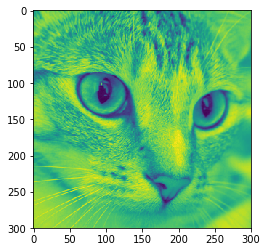

In [8]:
#Исходная фотография
from skimage import data
cat = data.chelsea()
img = (cat[:, 75:375, 0]) / 20
plt.imshow(img)

5486.441202728403


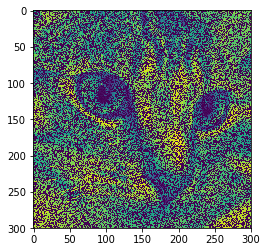

In [9]:
#Доля известных пикселей
d = 0.5
I = img
ind = np.random.choice(np.arange(I.shape[0] * I.shape[1]), int(d * I.shape[0] * I.shape[1]), replace=False)
v = I.ravel()[ind]

Test = np.zeros(I.shape)
np.put(Test, ind=ind, v=v)
plt.imshow(Test)

X0 = Test.copy()
Z0 = Test.copy()
lambda0 = np.random.rand(Test.shape[0] * Test.shape[1]).reshape(Test.shape)
#lambda0 = Test.copy()

E_low = norm(Test)
E_high = np.linalg.matrix_rank(Test) ** 0.5 * norm(Test)
E_mid = norm(I, ord='nuc')

print(norm(I, ord='nuc'))

PGD Modern (вторая постановка) с разными параметрами $\lambda$

In [12]:
N = 100
lams = [0.1, 0.5, 1.0, 2.0, 10.0]
res_obj_list = []
conv_X_list = []
conv_Z_list = []

for lam in lams:
    res_obj, res_X, X  = prox_alg_modern(f_grad, g_prox_modern, X0, N, ind, v, lam=lam)
    res_obj_list.append(res_obj)
    conv_X_list.append(res_X)
    print(lam)

0.1
0.5
1.0
2.0
10.0


(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350.]),
 <a list of 9 Text xticklabel objects>)

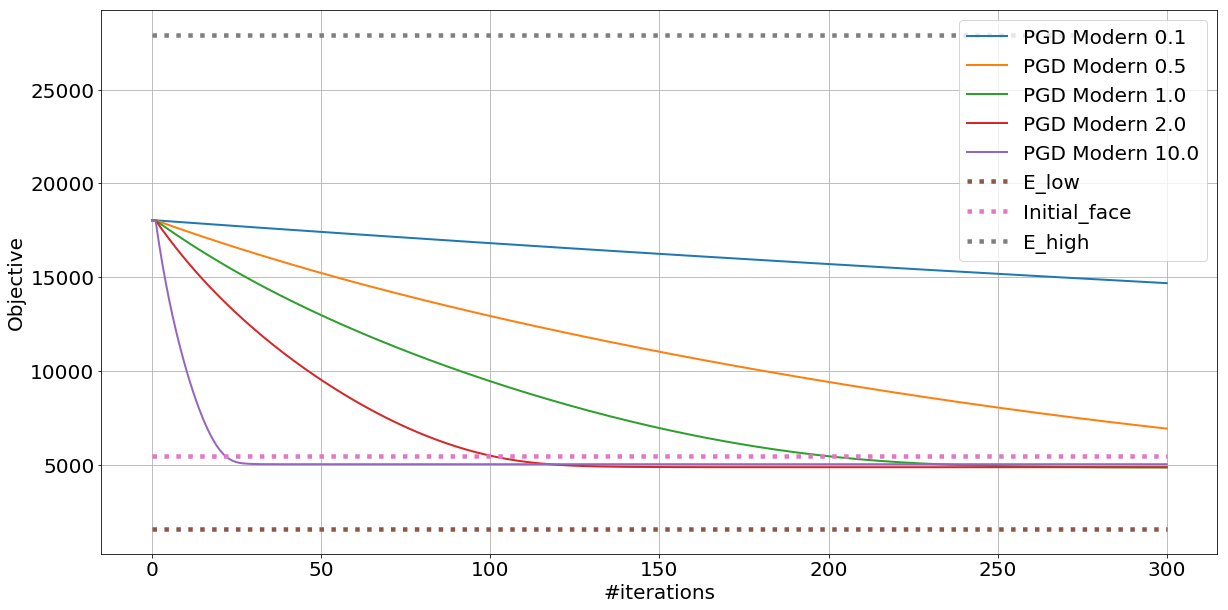

In [11]:
plt.figure(figsize=(20, 10))

for i in range(len(lams)):
    plt.plot(res_obj_list[i], label='PGD Modern ' + str(lams[i]), linewidth=2.0)
    


plt.plot(list(E_low * np.ones(N+1)), label="E_low", linewidth=4.5, linestyle=':')
plt.plot(list(E_mid * np.ones(N+1)), label="Initial_face",linewidth=4.5, linestyle=':')
plt.plot(list(E_high * np.ones(N+1)), label="E_high",linewidth=4.5, linestyle=':')

#plt.yscale("log")
#plt.xscale("log")
plt.legend(fontsize=20)
plt.xlabel("#iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

14697.303931434544
6958.578901610442
4891.727562389825
4903.544007599904
5062.975333628242


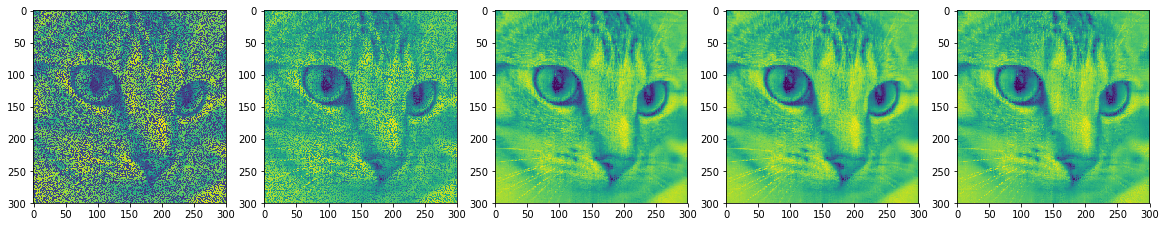

In [12]:
fig = plt.figure(figsize=(20, 10))
columns = 5
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(conv_X_list[i-1][-1])
    print(res_obj_list[i-1][-1])
plt.show()

Из двух картинок выше можно сделать вывод: чем больше лямбда, тем быстрее мы съедаем норму, но тем выше останавливаемся (см. фотографии кошечек). Остановка сходимости происходит примерно, когда разность между каждым сингулярным значением отимума и текущей матрицы становится меньше $\lambda$. Если сделать автоматический выбор шага, то метод почти наверняка ускорится.

PGD Armijo (с разными rho и beta)

In [35]:
N = 100
rb = [(0.7, 0.2), (0.7, 0.1), (0.8, 0.2), (0.8, 0.1), (0.9, 0.15), (0.95, 0.1)]
res_obj_list = []
conv_X_list = []
conv_Z_list = []

for rho, beta in rb:
    res_obj, res_X, X  = prox_alg_armijo(f_grad, g_prox, X0, N, ind, v, rho=rho, beta=beta)
    res_obj_list.append(res_obj)
    conv_X_list.append(res_X)
    print(rho, beta)

0.7 0.2
0.7 0.1
0.8 0.2
0.8 0.1
0.9 0.15
0.95 0.1


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text xticklabel objects>)

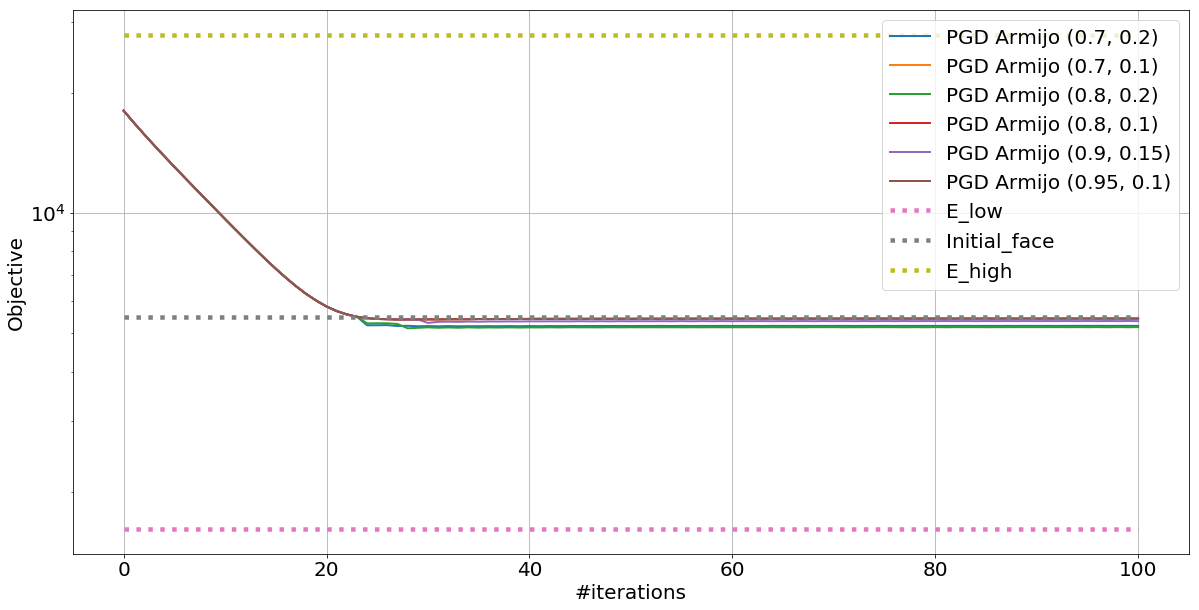

In [36]:
plt.figure(figsize=(20, 10))

for i in range(len(rb)):
    plt.plot(res_obj_list[i], label='PGD Armijo ' + str(rb[i]), linewidth=2.0)
    


plt.plot(list(E_low * np.ones(N+1)), label="E_low", linewidth=4.5, linestyle=':')
plt.plot(list(E_mid * np.ones(N+1)), label="Initial_face",linewidth=4.5, linestyle=':')
plt.plot(list(E_high * np.ones(N+1)), label="E_high",linewidth=4.5, linestyle=':')

plt.yscale("log")
#plt.xscale("log")
plt.legend(fontsize=20)
plt.xlabel("#iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

5208.432551557451
5432.1082373063855
5170.882080657853
5432.1082373063855
5352.049899738986
5432.1082373063855


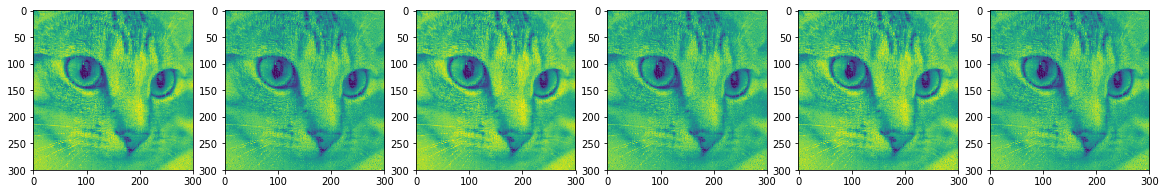

In [38]:
fig = plt.figure(figsize=(20, 10))
columns = 6
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(conv_X_list[i-1][-1])
    print(res_obj_list[i-1][-1])
plt.show()

Этот метод работает достаточно стабильно (хотя он и "субградиентный") за счёт автоматического выбора шага. Не так сильно зависит от параметров rho и beta. но чем больше beta (в разумном интервале) тем лучший результат (кошечки 1 и 3) мы получаем (при больших бета сильнее уменьшается шаг в конце и удаётся съесть маленькими кусочками больше нормы). Но modern с постоянным $\lambda$ надо сравнить с субградиентным с постоянным шагом.

PGD Const (с разным шагом step)

In [35]:
N = 300
steps = [0.05, 0.1, 0.5, 1.0, 10.0]
res_obj_list = []
conv_X_list = []
conv_Z_list = []

for step in steps:
    res_obj, res_X, X  = prox_alg_const(f_grad, g_prox, X0, N, ind, v, step=step)
    res_obj_list.append(res_obj)
    conv_X_list.append(res_X)
    print(step)

0.05
0.1
0.5
1.0
10.0


(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350.]),
 <a list of 9 Text xticklabel objects>)

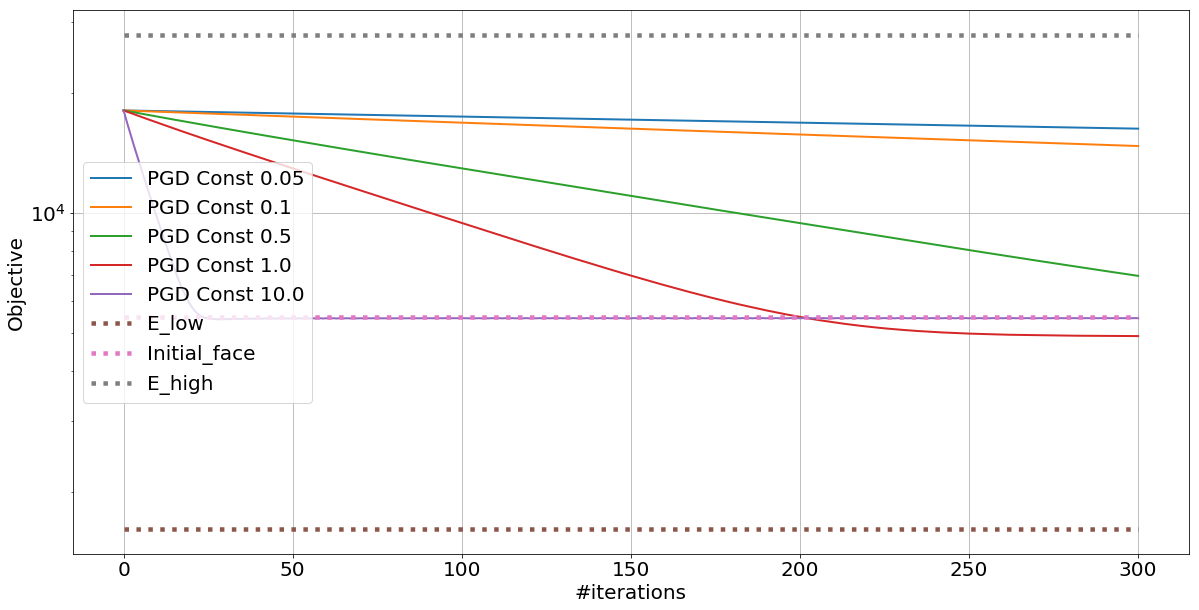

In [36]:
plt.figure(figsize=(20, 10))

for i in range(len(steps)):
    plt.plot(res_obj_list[i], label='PGD Const ' + str(steps[i]), linewidth=2.0)
    


plt.plot(list(E_low * np.ones(N+1)), label="E_low", linewidth=4.5, linestyle=':')
plt.plot(list(E_mid * np.ones(N+1)), label="Initial_face",linewidth=4.5, linestyle=':')
plt.plot(list(E_high * np.ones(N+1)), label="E_high",linewidth=4.5, linestyle=':')

plt.yscale("log")
#plt.xscale("log")
plt.legend(fontsize=20)
plt.xlabel("#iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

16243.37946953125
14693.517905637558
6946.083708758315
4906.840911610951
5439.974216176054


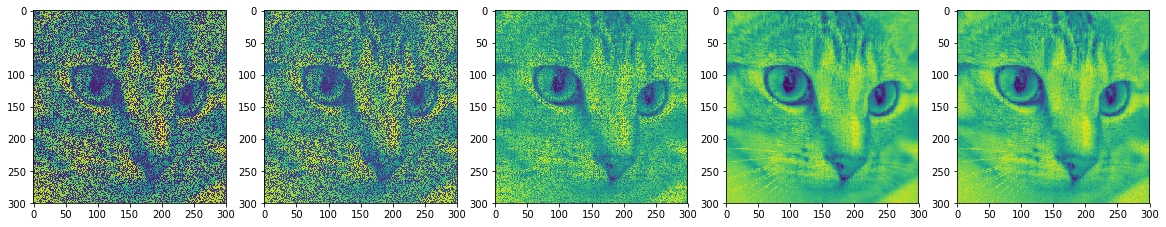

In [37]:
fig = plt.figure(figsize=(20, 10))
columns = 5
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(conv_X_list[i-1][-1])
    print(res_obj_list[i-1][-1])
plt.show()

Кому-то не хватило итераций, чтобы сойтись, кому-то хватило. Но алгоритмы с меньшим шагом достигнут лучшего результат при достаточном числе итераций.

ADMM

In [6]:
N = 150
rhos = [0.05, 0.1, 0.5, 1.0, 10.0, 100.0]
res_obj_list = []
conv_X_list = []
conv_Z_list = []

for rho in rhos:
    res_obj, conv_X, conv_Z = admm(update_x, update_z, rho, X0, Z0, lambda0, N)
    res_obj_list.append(res_obj)
    conv_X_list.append(conv_X)
    conv_Z_list.append(conv_Z)
    print(rho)

0.05
0.1
0.5
1.0
10.0
100.0


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 <a list of 10 Text xticklabel objects>)

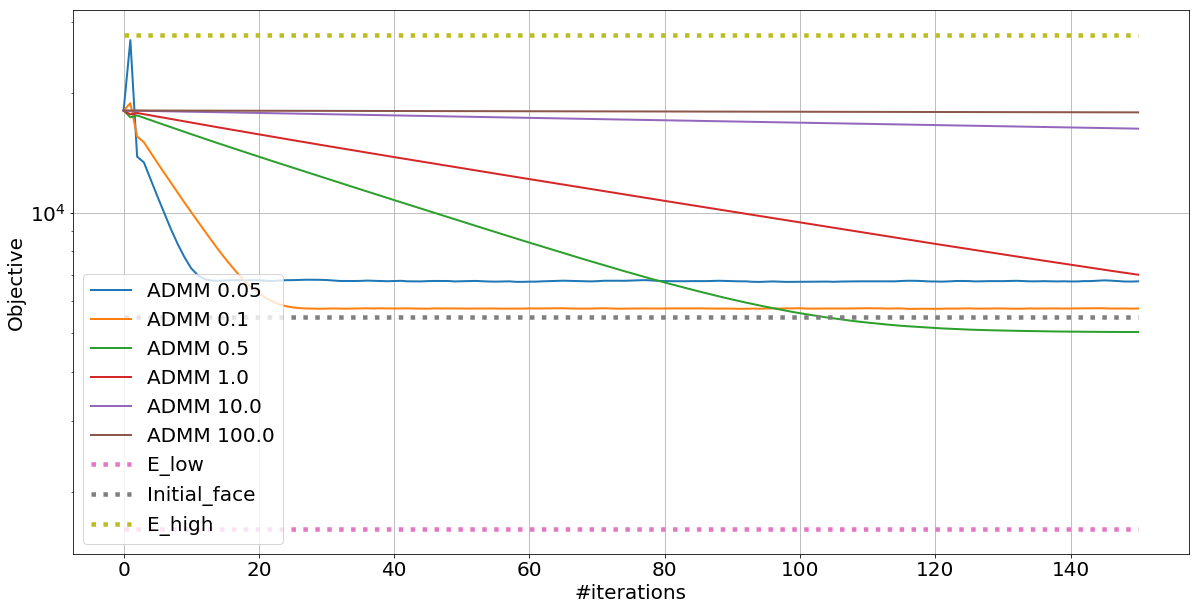

In [7]:
plt.figure(figsize=(20, 10))

for i in range(len(rhos)):
    plt.plot(res_obj_list[i], label='ADMM ' + str(rhos[i]), linewidth=2.0)
    


plt.plot(list(E_low * np.ones(N+1)), label="E_low", linewidth=4.5, linestyle=':')
plt.plot(list(E_mid * np.ones(N+1)), label="Initial_face",linewidth=4.5, linestyle=':')
plt.plot(list(E_high * np.ones(N+1)), label="E_high",linewidth=4.5, linestyle=':')

plt.yscale("log")
#plt.xscale("log")
plt.legend(fontsize=20)
plt.xlabel("#iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

6730.893607088995
5753.771884310393
5023.471336020059
6992.689300183998
16244.863962709574
17847.051681461857


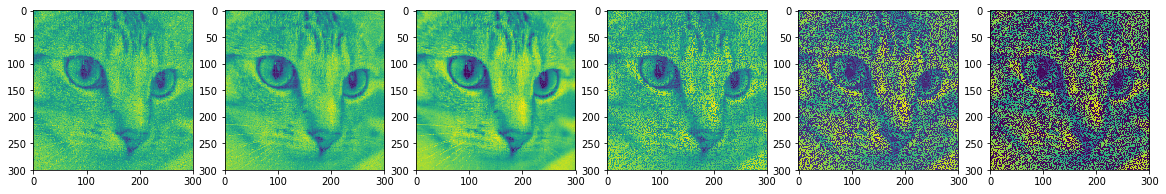

In [8]:
fig = plt.figure(figsize=(20, 10))
columns = 6
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(conv_X_list[i-1][-1])
    print(res_obj_list[i-1][-1])
plt.show()

Видно, что ADMM сильно зависит от параметра rho. Если сравнивать ADMM  соптимальным параметром rho = 1.0 и PGD Modern c оптимальной $\lambda = 1.0$, то при достаточно ьлизких минимуммах 4941 про 4891 ADMM сходится за 150 итераций, а PGD Modern за 250, так что по соотношению цена/качество в этом тесте ADMM получше.

In [9]:
del res_obj_list, conv_X_list, conv_Z_list

Итого: быстрее всего сходится PGD Armijo, но он достаточно сильно не доходит до минимума, и на каждой итерации у него есть несколько дополнительных вычислений ядерной нормы.  
ЕСли сравнивать оптимальные ADMM и PGD Modern, то ADMM быстрее, хотя и немного проигрывает в минимизации, но на качестве восстановления это не сказывается.

Для случайно сгенерированной матрицы

Эксперимент: генерирую случайную матрицу, оставляю изветснымии долю d элементов, запускаю алгоритмы с одинаковой случайной стартовой точки (для ADMM три случайных точки).

In [ ]:
np.random.seed(117)
#размер матрицы
n = 200
#доля известных элементов
d = 0.3
X = np.random.rand(n * n).reshape((n, n))

ind = np.random.choice(np.arange(n * n), int(d * n * n), replace=False)
v = X.ravel()[ind]

X0 = np.random.rand(n * n).reshape(X.shape)
Z0 = np.random.rand(n * n).reshape(X.shape)
lambda0 = np.random.rand(n * n).reshape(X.shape)

print(norm(X0, ord='nuc'), norm(X, ord='nuc'))

In [59]:
#np.random.seed(129)
#размер матрицы
n = 200
#доля известных элементов
d = 0.3
X = np.random.rand(n * n).reshape((n, n))

ind = np.random.choice(np.arange(n * n), int(d * n * n), replace=False)
v = X.ravel()[ind]

X0 = np.random.rand(n * n).reshape(X.shape)
Z0 = np.random.rand(n * n).reshape(X.shape)
lambda0 = np.random.rand(n * n).reshape(X.shape)

print(norm(X0, ord='nuc'), norm(X, ord='nuc'))

789.2563480583814 786.8570452579349


In [60]:
E_low = norm(X)
E_high = np.linalg.matrix_rank(X) ** 0.5 * norm(X)
E_mid = norm(X, ord='nuc')

In [74]:
N = 200
#N - исло итераций
res_obj_list = []
res_X_list = []
X_list = []

res_obj, res_X, X  = prox_alg_const(f_grad, g_prox, X0, N, ind, v, step=1.0)
res_obj_list.append(res_obj)
res_X_list.append(res_X)
X_list.append(X)
print('1')
res_obj, res_X, X  = prox_alg_armijo(f_grad, g_prox, X0, N, ind, v, rho=0.85, beta=0.2)
res_obj_list.append(res_obj)
res_X_list.append(res_X)
X_list.append(X)
print('3')
res_obj, res_X, X  = prox_alg_modern(f_grad, g_prox_modern, X0, N, ind, v, lam=1.0)
res_obj_list.append(res_obj)
res_X_list.append(res_X)
X_list.append(X)
print('4')
res_obj, X, Z = admm(update_x, update_z, 3.0, X0, Z0, lambda0, N)
res_obj_list.append(res_obj)
res_X_list.append(res_X)
X_list.append(X)
print('5')

1
3
4
5


(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
 <a list of 11 Text xticklabel objects>)

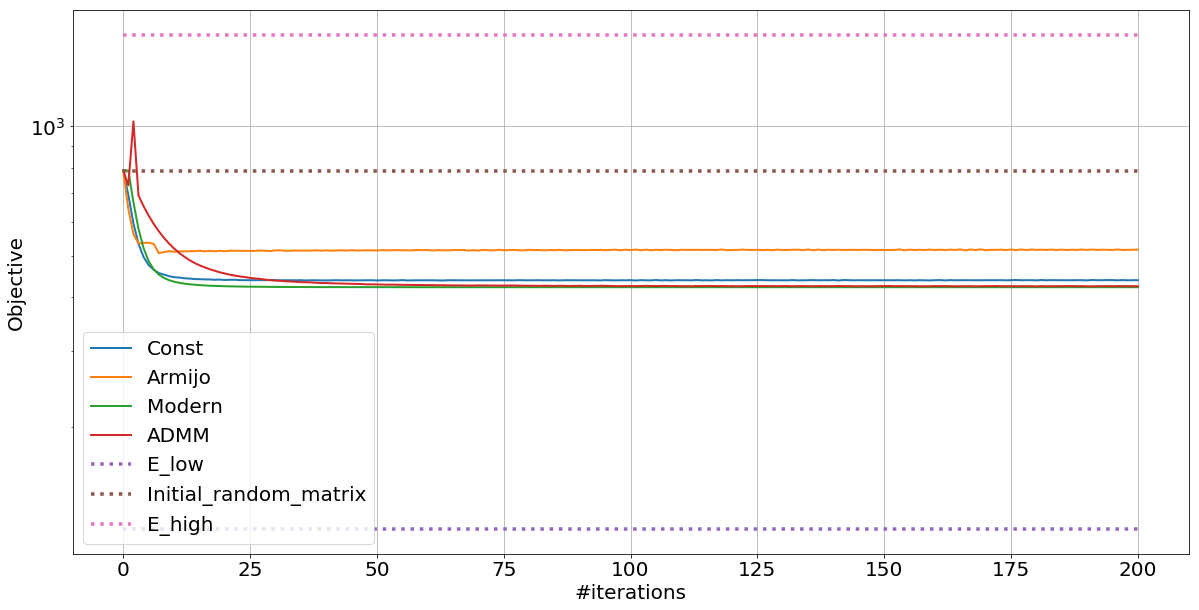

In [75]:
plt.figure(figsize=(20, 10))

plt.plot(res_obj_list[0], label="Const", linewidth=2.0)
plt.plot(res_obj_list[1], label="Armijo", linewidth=2.0)
plt.plot(res_obj_list[2], label="Modern", linewidth=2.0)
plt.plot(res_obj_list[3], label="ADMM", linewidth=2.0)

plt.plot(list(E_low * np.ones(N+1)), label="E_low", linewidth=3.5, linestyle=':')
plt.plot(list(E_mid * np.ones(N+1)), label="Initial_random_matrix",linewidth=3.5, linestyle=':')
plt.plot(list(E_high * np.ones(N+1)), label="E_high",linewidth=3.5, linestyle=':')

plt.yscale("log")
#plt.xscale("log")
plt.legend(fontsize=20)
plt.xlabel("#iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

На такой случайной задаче методы сравнивать уже сложнее. ADMM по-прежнему сильно зависит от rho, а для PGD Modern $\lambda$ это "скорость" убывания нормы, поэтому если от начальной точки до оптимума не большое расстояние, то PGD Modern стабильнее в плане подбора парметров и быстрее ADMM. 

Сходимость к нулевой матрице

Одна из слабых точек методов это задачи с большим количеством нулей в качестве известных элементов. Здесь отлично работает метод из второй постановки (PGD Modern), что понятно. Субградиентные методы плохо сходятся к 0 (с постоянным шагом останавливается на некотором уровне далеком от 0). PGD Aramijo и ADMM нужно намного больше итераций чтобы сойтись.

In [25]:
np.random.seed(129)
#размер матрицы
n = 100
#доля известных элементов
d = 0.3
X = np.zeros((n, n))

ind = np.random.choice(np.arange(n * n), int(d * n * n), replace=False)
v = X.ravel()[ind]

X0 = np.random.rand(n * n).reshape(X.shape)
Z0 = np.random.rand(n * n).reshape(X.shape)
lambda0 = np.random.rand(n * n).reshape(X.shape)
print(norm(X0, ord='nuc'))

292.2104033011033


In [30]:
N = 1000
#N - исло итераций
res_obj_list = []
res_X_list = []
X_list = []

res_obj, res_X, X  = prox_alg_const(f_grad, g_prox, X0, N, ind, v, step=1.0)
res_obj_list.append(res_obj)
res_X_list.append(res_X)
X_list.append(X)
print('1')
res_obj, res_X, X  = prox_alg_armijo(f_grad, g_prox, X0, N, ind, v, rho=0.85, beta=0.2)
res_obj_list.append(res_obj)
res_X_list.append(res_X)
X_list.append(X)
print('3')
res_obj, res_X, X  = prox_alg_modern(f_grad, g_prox_modern, X0, N, ind, v, lam=1.0)
res_obj_list.append(res_obj)
res_X_list.append(res_X)
X_list.append(X)
print('4')
res_obj, X, Z = admm(update_x, update_z, 50.0, X0, Z0, lambda0, N)
res_obj_list.append(res_obj)
res_X_list.append(res_X)
X_list.append(X)
print('5')

1
3
4
5


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 8 Text xticklabel objects>)

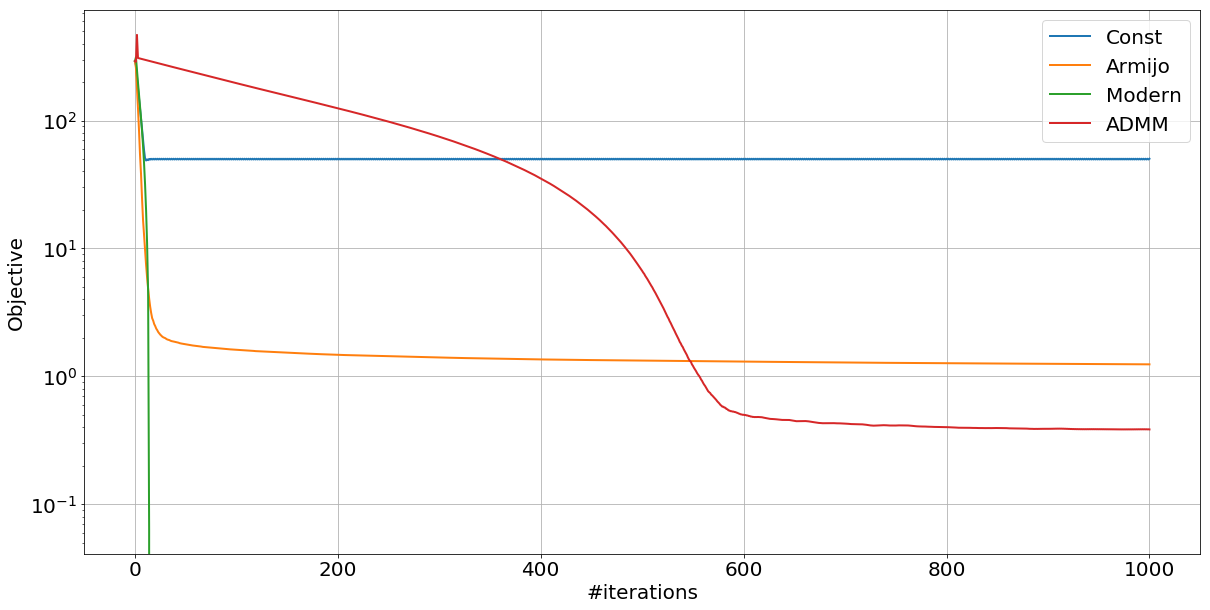

In [31]:
plt.figure(figsize=(20, 10))

plt.plot(res_obj_list[0], label="Const", linewidth=2.0)
plt.plot(res_obj_list[1], label="Armijo", linewidth=2.0)
plt.plot(res_obj_list[2], label="Modern", linewidth=2.0)
plt.plot(res_obj_list[3], label="ADMM", linewidth=2.0)

plt.yscale("log")
#plt.xscale("log")
plt.legend(fontsize=20)
plt.xlabel("#iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

Итого в плане независимости от параметров и скорости сходимости PGD Modern (из второй постановки) кажется оптимальных среди этих алгоритмов в моей реализации. Но при правильном подборе параметров PGD Aramijo, PGD Modern и ADMM покажут примерно одинаковые результаты (особенно в задачах с достаточно большим рангом у оптимума, а для восстановления фотографий это выполнено) и каждый из них можно применять в зависимости от особенностей конкретной задачи.